## Instructions

Test MBAR by performing statistical tests on a set of of 1D harmonic oscillators, for which
the true free energy differences can be computed analytically. A number of replications of an experiment in which i.i.d. samples are drawn from a set of $K$ harmonic oscillators are produced.  For each replicate, we estimate the dimensionless free
energy differences and mean-square displacements (an observable), as well as their uncertainties.

For a 1D harmonic oscillator with spring constant $K$, the potential is given by

$V(x;K) = (\frac{1}{2}K(x-x_0)^2$

The equilibrium distribution is given analytically by:

$p(x;\beta,K) = \sqrt{\frac{\beta K}{2\pi}} e^{-\frac{\beta K (x-x_0)^2}{2}}$

The dimensionless free energy is therefore:

  $f(\beta,K) = - \frac{1}{2} \ln \left( \frac{2 \pi}{\beta K} \right)$

## IMPORTS

In [1]:
import sys
import numpy as np
from pymbar import testsystems, exp, exp_gauss, bar, MBAR, FES
from pymbar.utils import ParameterError

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
import logging
import sys

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [4]:
import matplotlib.pyplot as plt

## HELPER FUNCTIONS


In [5]:
def stddev_away(namex, errorx, dx):
    if dx > 0:
        print(f"{namex} differs by {errorx / dx:.3f} standard deviations from analytical")
    else:
        print(f"{namex} differs by an undefined number of standard deviations")

Generate the analytical estimates of various functions of a harmonic oscillator.

In [6]:
def get_analytical(beta, K, O, observables):
    # For a harmonic oscillator with spring constant K,
    # x ~ Normal(x_0, sigma^2), where sigma = 1/sqrt(beta K)

    # Compute the absolute dimensionless free energies of each oscillator analytically.
    # f = - ln(sqrt((2 pi)/(beta K)) )
    print("Computing dimensionless free energies analytically...")
    sigma = (beta * K) ** -0.5
    f_k_analytical = -np.log(np.sqrt(2 * np.pi) * sigma)
    Delta_f_ij_analytical = f_k_analytical - np.vstack(f_k_analytical)
    A_k_analytical = dict()
    A_ij_analytical = dict()
    for observe in observables:
        if observe == "RMS displacement":
            # mean square displacement
            A_k_analytical[observe] = sigma
        if observe == "potential energy":
            # By equipartition
            A_k_analytical[observe] = 1 / (2 * beta) * np.ones(len(K), float)
        if observe == "position":
            # observable is the position
            A_k_analytical[observe] = O
        if observe == "position^2":
            # observable is the position^2
            A_k_analytical[observe] = (1 + beta * K * O**2) / (beta * K)
        A_ij_analytical[observe] = A_k_analytical[observe] - np.vstack(A_k_analytical[observe])
    return f_k_analytical, Delta_f_ij_analytical, A_k_analytical, A_ij_analytical

## PARAMETERS

Enter some parameters here to describe the system.

In [7]:
K_k = np.array([25, 16, 9, 4, 1, 1])  # spring constants for each state
O_k = np.array([0, 1, 2, 3, 4, 5])  # offsets for spring constants
# number of samples from each state (can be zero for some states)
N_k = 10 * np.array([1000, 1000, 1000, 1000, 0, 1000])
Nk_ne_zero = N_k != 0
beta = 1.0  # inverse temperature for all simulations
K_extra = np.array([20, 12, 6, 2, 1])
O_extra = np.array([0.5, 1.5, 2.5, 3.5, 4.5])
observables = ["position", "position^2", "potential energy", "RMS displacement"]

Let's plot the harmonic oscillators we are trying to sample. 

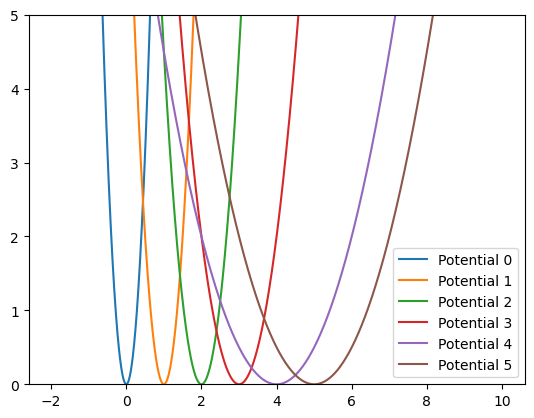

In [94]:
xrange = np.linspace(-2,10,10000)
for k in range(len(K_k)):
    yk = (K_k[k]*(xrange-O_k[k])**2)/2
    plt.plot(xrange,yk,label=f"Potential {k}") 
plt.legend()
plt.ylim(0,5)
plt.show()

Now let's look at the probability distributions.

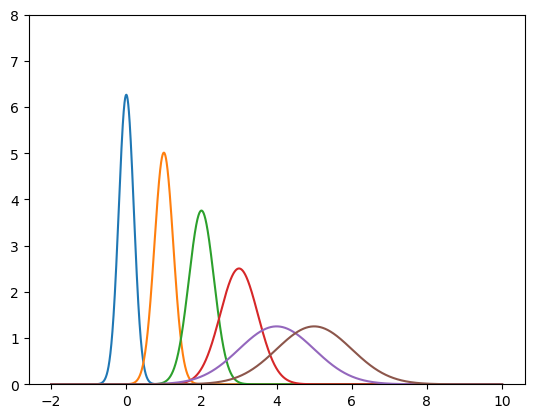

In [96]:
xrange = np.linspace(-2,10,10000)
for k in range(len(K_k)):
    yk = np.sqrt(K_k[k]/2*np.pi)*np.exp(-(K_k[k]*(xrange-O_k[k])**2)/2)
    plt.plot(xrange,yk,label=f"Gaussian {k}") 
plt.ylim(0,8)
plt.show()

Note that the state with center at $x=4$ has no samples drawn from it.  In many of the examples below, we will be looking at the free energy and expectations of this state using the samples from the other states.

Set random number seeds.

In [8]:
seed = None
# Uncomment the following line to seed the random number generated to
# produce reproducible output.
seed = 0
np.random.seed(seed)

## MAIN CODE


Determine number of simulations that were specified above.

In [9]:
K = np.size(N_k)
if np.shape(K_k) != np.shape(N_k):
    msg = f"K_k ({np.shape(K_k):d}) and N_k ({np.shape(N_k):d}) must have same dimensions."
    raise ParameterError(msg)
if np.shape(O_k) != np.shape(N_k):
    msg = f"O_k ({np.shape(K_k):d}) and N_k ({np.shape(N_k):d}) must have same dimensions."
    raise ParameterError(msg)

Determine maximum number of samples to be drawn for any state.

In [10]:
N_max = np.max(N_k)

In [11]:
f_k_analytical, Delta_f_ij_analytical, A_k_analytical, A_ij_analytical = get_analytical(
    beta, K_k, O_k, observables
)

Computing dimensionless free energies analytically...


In [12]:
print(f"This script will draw samples from {K:d} harmonic oscillators.")
print("The harmonic oscillators have equilibrium positions:", O_k)
print("and spring constants:", K_k)
print(
    "and the following number of samples will be drawn from each",
    "(can be zero if no samples drawn):",
    N_k,
)

This script will draw samples from 6 harmonic oscillators.
The harmonic oscillators have equilibrium positions: [0 1 2 3 4 5]
and spring constants: [25 16  9  4  1  1]
and the following number of samples will be drawn from each (can be zero if no samples drawn): [10000 10000 10000 10000     0 10000]


Now, generate independent data samples from $K$ one-dimensional harmonic oscillators centered at the specified locations.

In [13]:
randomsample = testsystems.harmonic_oscillators.HarmonicOscillatorsTestCase(
    O_k=O_k, K_k=K_k, beta=beta
)
x_kn, u_kln, N_k = randomsample.sample(N_k, mode="u_kln", seed=seed)

Get the unreduced energies.

In [14]:
U_kln = u_kln / beta

Estimate free energies and expectations with BAR, first initializing it.

In [15]:
mbar = MBAR(u_kln, N_k, relative_tolerance=1.0e-10, verbose=True)
# Get matrix of dimensionless free energy differences and uncertainty estimate.

INFO:pymbar.mbar:K (total states) = 6, total samples = 50000
INFO:pymbar.mbar:N_k = 
INFO:pymbar.mbar:[10000 10000 10000 10000     0 10000]
INFO:pymbar.mbar:There are 5 states with samples.
INFO:pymbar.mbar:Initializing free energies to zero.
INFO:pymbar.mbar:Initial dimensionless free energies with method zeros
INFO:pymbar.mbar:f_k = 
INFO:pymbar.mbar:[0. 0. 0. 0. 0. 0.]
******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such 

### Testing compute_free_energy_differences


In [16]:
results = mbar.compute_free_energy_differences()
Delta_f_ij_estimated = results["Delta_f"]
dDelta_f_ij_estimated = results["dDelta_f"]

Compute error from analytical free energy differences.

In [17]:
Delta_f_ij_error = Delta_f_ij_estimated - Delta_f_ij_analytical

In [18]:
print("Error in free energies is:")
print(Delta_f_ij_error)
print("Uncertainty in free energies is:")
print(dDelta_f_ij_estimated)

Error in free energies is:
[[ 0.         -0.00507292  0.01226345  0.02417993  0.03509095  0.03712769]
 [ 0.00507292  0.          0.01733637  0.02925285  0.04016388  0.04220061]
 [-0.01226345 -0.01733637  0.          0.01191648  0.0228275   0.02486424]
 [-0.02417993 -0.02925285 -0.01191648  0.          0.01091103  0.01294776]
 [-0.03509095 -0.04016388 -0.0228275  -0.01091103  0.          0.00203674]
 [-0.03712769 -0.04220061 -0.02486424 -0.01294776 -0.00203674  0.        ]]
Uncertainty in free energies is:
[[0.         0.07100713 0.08109591 0.08450777 0.08621464 0.08859106]
 [0.07100713 0.         0.03654687 0.04359901 0.04684609 0.05106776]
 [0.08109591 0.03654687 0.         0.01988063 0.02659403 0.03325712]
 [0.08450777 0.04359901 0.01988063 0.         0.0150578  0.02393041]
 [0.08621464 0.04684609 0.02659403 0.0150578  0.         0.01018445]
 [0.08859106 0.05106776 0.03325712 0.02393041 0.01018445 0.        ]]


In [19]:
print("Standard deviations away is:")
# mathematical manipulation to avoid dividing by zero errors; we don't care
# about the diagnonals, since they are identically zero.
df_ij_mod = dDelta_f_ij_estimated + np.identity(K)
stdevs = np.abs(Delta_f_ij_error / df_ij_mod)
for k in range(K):
    stdevs[k, k] = 0
print(stdevs)

Standard deviations away is:
[[0.         0.07144245 0.15122157 0.28612665 0.40701847 0.41909071]
 [0.07144245 0.         0.47436002 0.6709521  0.85735808 0.82636498]
 [0.15122157 0.47436002 0.         0.59940132 0.85836953 0.7476365 ]
 [0.28612665 0.6709521  0.59940132 0.         0.72460967 0.54105905]
 [0.40701847 0.85735808 0.85836953 0.72460967 0.         0.19998505]
 [0.41909071 0.82636498 0.7476365  0.54105905 0.19998505 0.        ]]


### Testing bar

In [20]:
nonzero_indices = np.arange(K)[Nk_ne_zero]
Knon = len(nonzero_indices)
for i in range(Knon - 1):
    k = nonzero_indices[i]
    k1 = nonzero_indices[i + 1]
    w_F = u_kln[k, k1, 0 : N_k[k]] - u_kln[k, k, 0 : N_k[k]]  # forward work
    w_R = u_kln[k1, k, 0 : N_k[k1]] - u_kln[1, k1, 0 : N_k[k1]]  # reverse work
    results = bar(w_F, w_R)
    df_bar = results["Delta_f"]
    ddf_bar = results["dDelta_f"]
    bar_analytical = f_k_analytical[k1] - f_k_analytical[k]
    bar_error = bar_analytical - df_bar
    print(
        f"BAR estimator for reduced free energy from states {k:d} to {k1:d} is {df_bar:f} +/- {ddf_bar:f}"
    )
    stddev_away("BAR estimator", bar_error, ddf_bar)

BAR estimator for reduced free energy from states 0 to 1 is -0.230716 +/- 0.071054
BAR estimator differs by 0.107 standard deviations from analytical
BAR estimator for reduced free energy from states 1 to 2 is 1.578985 +/- 0.022693
BAR estimator differs by -82.258 standard deviations from analytical
BAR estimator for reduced free energy from states 2 to 3 is 2.240304 +/- 0.008230
BAR estimator differs by -321.473 standard deviations from analytical
BAR estimator for reduced free energy from states 3 to 5 is 1.345117 +/- 0.011500
BAR estimator differs by -177.247 standard deviations from analytical


### Testing exp

In [21]:
print("EXP forward free energy")
for k in range(K - 1):
    if N_k[k] != 0:
        # forward work
        w_F = u_kln[k, k + 1, 0 : N_k[k]] - u_kln[k, k, 0 : N_k[k]]
        results = exp(w_F)
        df_exp = results["Delta_f"]
        ddf_exp = results["dDelta_f"]
        exp_analytical = f_k_analytical[k + 1] - f_k_analytical[k]
        exp_error = exp_analytical - df_exp
        print(f"df from states {k:d} to {k + 1:d} is {df_exp:f} +/- {ddf_exp:f}")
        stddev_away("df", exp_error, ddf_exp)

EXP forward free energy
df from states 0 to 1 is 1.557946 +/- 0.427853
df differs by -4.163 standard deviations from analytical
df from states 1 to 2 is 0.351022 +/- 0.158750
df differs by -4.023 standard deviations from analytical
df from states 2 to 3 is -0.156088 +/- 0.152335
df differs by -1.637 standard deviations from analytical
df from states 3 to 4 is -0.559564 +/- 0.075615
df differs by -1.767 standard deviations from analytical


In [22]:
print("EXP reverse free energy")
for k in range(1, K):
    if N_k[k] != 0:
        w_R = u_kln[k, k - 1, 0 : N_k[k]] - u_kln[k, k, 0 : N_k[k]]  # reverse work
        results = exp(w_R)
        df_exp = -results["Delta_f"]
        ddf_exp = results["dDelta_f"]
        exp_analytical = f_k_analytical[k] - f_k_analytical[k - 1]
        exp_error = exp_analytical - df_exp
        print(f"df from states {k:d} to {k - 1:d} is {df_exp:f} +/- {ddf_exp:f}")
        stddev_away("df", exp_error, ddf_exp)

EXP reverse free energy
df from states 1 to 0 is 0.671875 +/- 0.860890
df differs by -1.040 standard deviations from analytical
df from states 2 to 1 is 0.174442 +/- 0.385955
df differs by -1.197 standard deviations from analytical
df from states 3 to 2 is -0.308404 +/- 0.039600
df differs by -2.451 standard deviations from analytical
df from states 5 to 4 is 0.004544 +/- 0.012931
df differs by -0.351 standard deviations from analytical


### Testing computeGauss
Gaussian estimate of free energy

In [23]:
print("Gaussian forward estimate")
for k in range(K - 1):
    if N_k[k] != 0:
        w_F = u_kln[k, k + 1, 0 : N_k[k]] - u_kln[k, k, 0 : N_k[k]]  # forward work
        results = exp_gauss(w_F)
        df_gauss = results["Delta_f"]
        ddf_gauss = results["dDelta_f"]
        gauss_analytical = f_k_analytical[k + 1] - f_k_analytical[k]
        gauss_error = gauss_analytical - df_gauss
        print(
            f"df for reduced free energy from states {k:d} to {k + 1:d} is {df_gauss:f} +/- {ddf_gauss:f}"
        )
        stddev_away("df", gauss_error, ddf_gauss)

Gaussian forward estimate
df for reduced free energy from states 0 to 1 is 2.865610 +/- 0.077715
df differs by -39.745 standard deviations from analytical
df for reduced free energy from states 1 to 2 is 1.693329 +/- 0.042784
df differs by -46.303 standard deviations from analytical
df for reduced free energy from states 2 to 3 is 0.787004 +/- 0.019163
df differs by -62.229 standard deviations from analytical
df for reduced free energy from states 3 to 4 is -0.150566 +/- 0.008282
df differs by -65.517 standard deviations from analytical


In [24]:
print("Gaussian reverse estimate")
for k in range(1, K):
    if N_k[k] != 0:
        # reverse work
        w_R = u_kln[k, k - 1, 0 : N_k[k]] - u_kln[k, k, 0 : N_k[k]]
        results = exp_gauss(w_R)
        df_gauss = results["Delta_f"]
        ddf_gauss = results["dDelta_f"]
        gauss_analytical = f_k_analytical[k] - f_k_analytical[k - 1]
        gauss_error = gauss_analytical - df_gauss
        print(
            f"df for reduced free energy from states {k:d} to {k - 1:d} is {df_gauss:f} +/- {ddf_gauss:f}"
        )
        stddev_away("df", gauss_error, ddf_gauss)

Gaussian reverse estimate
df for reduced free energy from states 1 to 0 is -6.573216 +/- 0.281626
df differs by 22.548 standard deviations from analytical
df for reduced free energy from states 2 to 1 is -5.838857 +/- 0.207714
df differs by 26.725 standard deviations from analytical
df for reduced free energy from states 3 to 2 is -5.442000 +/- 0.156385
df differs by 32.206 standard deviations from analytical
df for reduced free energy from states 5 to 4 is -0.000223 +/- 0.012188
df differs by 0.018 standard deviations from analytical


### Testing compute_expectations


In [25]:
A_kn_all = dict()
A_k_estimated_all = dict()
A_kl_estimated_all = dict()
N = np.sum(N_k)

In [26]:
for observe in observables:
    print("============================================")
    print(f"      Testing observable '{observe}'")
    print("============================================")
    if observe == "RMS displacement":
        state_dependent = True
        A_kn = np.zeros([K, N], dtype=np.float64)
        n = 0
        for k in range(K):
            for nk in range(N_k[k]):
                # observable is the squared displacement
                A_kn[:, n] = (x_kn[k, nk] - O_k[:]) ** 2
                n += 1

    # observable is the potential energy, a 3D array since the
    # potential energy is a function of the thermodynamic state
    elif observe == "potential energy":
        state_dependent = True
        A_kn = np.zeros([K, N], dtype=np.float64)
        n = 0
        for k in range(0, K):
            for nk in range(0, N_k[k]):
                A_kn[:, n] = U_kln[k, :, nk]
                n += 1

    # observable for estimation is the position
    elif observe == "position":
        state_dependent = False
        A_kn = np.zeros([K, N_max], dtype=np.float64)
        for k in range(0, K):
            A_kn[k, 0 : N_k[k]] = x_kn[k, 0 : N_k[k]]

    # observable for estimation is the position^2
    elif observe == "position^2":
        state_dependent = False
        A_kn = np.zeros([K, N_max], dtype=np.float64)
        for k in range(0, K):
            A_kn[k, 0 : N_k[k]] = x_kn[k, 0 : N_k[k]] ** 2
    results = mbar.compute_expectations(A_kn, state_dependent=state_dependent)
    A_k_estimated = results["mu"]
    dA_k_estimated = results["sigma"]

    # need to additionally transform to get the square root
    if observe == "RMS displacement":
        A_k_estimated = np.sqrt(A_k_estimated)
        # Compute error from analytical observable estimate.
        dA_k_estimated = dA_k_estimated / (2 * A_k_estimated)
    As_k_estimated = np.zeros([K], np.float64)
    dAs_k_estimated = np.zeros([K], np.float64)

    # 'standard' expectation averages - not defined if no samples
    nonzeros = np.arange(K)[Nk_ne_zero]
    totaln = 0
    for k in nonzeros:
        if (observe == "position") or (observe == "position^2"):
            As_k_estimated[k] = np.average(A_kn[k, 0 : N_k[k]])
            dAs_k_estimated[k] = np.sqrt(np.var(A_kn[k, 0 : N_k[k]]) / (N_k[k] - 1))
        elif (observe == "RMS displacement") or (observe == "potential energy"):
            totalp = totaln + N_k[k]
            As_k_estimated[k] = np.average(A_kn[k, totaln:totalp])
            dAs_k_estimated[k] = np.sqrt(np.var(A_kn[k, totaln:totalp]) / (N_k[k] - 1))
            totaln = totalp
            if observe == "RMS displacement":
                As_k_estimated[k] = np.sqrt(As_k_estimated[k])
                dAs_k_estimated[k] = dAs_k_estimated[k] / (2 * As_k_estimated[k])
    A_k_error = A_k_estimated - A_k_analytical[observe]
    As_k_error = As_k_estimated - A_k_analytical[observe]
    print("------------------------------")
    print("Now testing 'averages' mode")
    print("------------------------------")
    print(f"Analytical estimator of {observe} is")
    print(A_k_analytical[observe])
    print(f"MBAR estimator of the {observe} is")
    print(A_k_estimated)
    print("MBAR estimators differ by X standard deviations")
    stdevs = np.abs(A_k_error / dA_k_estimated)
    print(stdevs)
    print(f"Standard estimator of {observe} is (states with samples):")
    print(As_k_estimated[Nk_ne_zero])
    print("Standard estimators differ by X standard deviations (states with samples)")
    stdevs = np.abs(As_k_error[Nk_ne_zero] / dAs_k_estimated[Nk_ne_zero])
    print(stdevs)
    results = mbar.compute_expectations(
        A_kn, state_dependent=state_dependent, output="differences"
    )
    A_kl_estimated = results["mu"]
    dA_kl_estimated = results["sigma"]
    print("------------------------------")
    print("Now testing 'differences' mode")
    print("------------------------------")
    if (
        "RMS displacement" != observe
    ):  # can't test this, because we're actually computing the expectation of
        # the mean square displacement, and so the differences are <a_i^2> - <a_j^2>,
        # not sqrt<a_i>^2 - sqrt<a_j>^2
        A_kl_analytical = A_k_analytical[observe] - np.vstack(A_k_analytical[observe])
        A_kl_error = A_kl_estimated - A_kl_analytical
        print(f"Analytical estimator of differences of {observe} is")
        print(A_kl_analytical)
        print(f"MBAR estimator of the differences of {observe} is")
        print(A_kl_estimated)
        print("MBAR estimators differ by X standard deviations")
        stdevs = np.abs(A_kl_error / (dA_kl_estimated + np.identity(K)))
        for k in range(K):
            stdevs[k, k] = 0
        print(stdevs)

    # save up the A_k for use in compute_multiple_expectations
    A_kn_all[observe] = A_kn
    A_k_estimated_all[observe] = A_k_estimated
    A_kl_estimated_all[observe] = A_kl_estimated

      Testing observable 'position'
------------------------------
Now testing 'averages' mode
------------------------------
Analytical estimator of position is
[0 1 2 3 4 5]
MBAR estimator of the position is
[-3.48469785e-03  1.00188217e+00  1.99757918e+00  2.99873349e+00
  3.99464907e+00  4.99760397e+00]
MBAR estimators differ by X standard deviations
[1.7664237  0.7750278  0.79363382 0.28297505 0.45542995 0.24537691]
Standard estimator of position is (states with samples):
[-3.68674403e-03  1.00274700e+00  1.99811239e+00  2.99899704e+00
  4.99614443e+00]
Standard estimators differ by X standard deviations (states with samples)
[1.86650558 1.10643016 0.56781776 0.19885105 0.38694585]
------------------------------
Now testing 'differences' mode
------------------------------
Analytical estimator of differences of position is
[[ 0  1  2  3  4  5]
 [-1  0  1  2  3  4]
 [-2 -1  0  1  2  3]
 [-3 -2 -1  0  1  2]
 [-4 -3 -2 -1  0  1]
 [-5 -4 -3 -2 -1  0]]
MBAR estimator of the differences

In [27]:
##Testing compute_multiple_expectations"


Exclude the potential and RMS displacemet for now, as they are not functions
of a single state

In [28]:
observables_single = ["position", "position^2"]

In [29]:
A_ikn = np.zeros([len(observables_single), K, N_k.max()], np.float64)
for i, observe in enumerate(observables_single):
    A_ikn[i, :, :] = A_kn_all[observe]
for i in range(K):
    results = mbar.compute_multiple_expectations(A_ikn, u_kln[:, i, :], compute_covariance=True)
    A_i = results["mu"]
    dA_ij = results["sigma"]
    Ca_ij = results["covariances"]
    print(f"Averages for state {i:d}")
    print(A_i)
    print(f"Uncertainties for state {i:d}")
    print(dA_ij)
    print(f"Correlation matrix between observables for state {i:d}")
    print(Ca_ij)

Averages for state 0
[-0.0034847   0.03920353]
Uncertainties for state 0
[0.00197274 0.00053523]
Correlation matrix between observables for state 0
[[0.00385412 0.00356351]
 [0.00356351 0.00346764]]
Averages for state 1
[1.00188217 1.06513239]
Uncertainties for state 1
[0.00242852 0.00487326]
Correlation matrix between observables for state 1
[[0.00078402 0.00075975]
 [0.00075975 0.0007458 ]]
Averages for state 2
[1.99757918 4.10098618]
Uncertainties for state 2
[0.00305029 0.01204903]
Correlation matrix between observables for state 2
[[0.00051009 0.00051456]
 [0.00051456 0.00052241]]
Averages for state 3
[2.99873349 9.24130475]
Uncertainties for state 3
[0.0044757  0.02683734]
Correlation matrix between observables for state 3
[[0.00063767 0.00064802]
 [0.00064802 0.00066131]]
Averages for state 4
[ 3.99464907 16.96750717]
Uncertainties for state 4
[0.01174919 0.09230332]
Correlation matrix between observables for state 4
[[0.00082498 0.00086563]
 [0.00086563 0.00091518]]
Averages fo


### Testing compute_entropy_and_enthalpy


In [30]:
results = mbar.compute_entropy_and_enthalpy(u_kn=u_kln, verbose=True)
Delta_f_ij = results["Delta_f"]
dDelta_f_ij = results["dDelta_f"]
Delta_u_ij = results["Delta_u"]
dDelta_u_ij = results["dDelta_u"]
Delta_s_ij = results["Delta_s"]
dDelta_s_ij = results["dDelta_s"]

INFO:pymbar.mbar:Computing average energy and entropy by MBAR.


In [31]:
print("Free energies")
print(Delta_f_ij)
print(dDelta_f_ij)
diffs1 = Delta_f_ij - Delta_f_ij_estimated
print(
    f"maximum difference between values computed here and in computeFreeEnergies is {np.max(diffs1):g}"
)
if np.max(np.abs(diffs1)) > 1.0e-10:
    print("Difference in values from computeFreeEnergies")
    print(diffs1)
diffs2 = dDelta_f_ij - dDelta_f_ij_estimated
print(
    f"maximum difference between uncertainties computed here and in computeFreeEnergies is {np.max(diffs2):g}"
)
if np.max(np.abs(diffs2)) > 1.0e-10:
    print("Difference in expectations from computeFreeEnergies")
    print(diffs2)

Free energies
[[ 0.         -0.22821647 -0.49856217 -0.89211081 -1.57434696 -1.57231022]
 [ 0.22821647  0.         -0.2703457  -0.66389433 -1.34613049 -1.34409375]
 [ 0.49856217  0.2703457   0.         -0.39354863 -1.07578479 -1.07374805]
 [ 0.89211081  0.66389433  0.39354863  0.         -0.68223615 -0.68019942]
 [ 1.57434696  1.34613049  1.07578479  0.68223615  0.          0.00203674]
 [ 1.57231022  1.34409375  1.07374805  0.68019942 -0.00203674  0.        ]]
[[0.         0.07100713 0.08109591 0.08450777 0.08621464 0.08859106]
 [0.07100713 0.         0.03654687 0.04359901 0.04684609 0.05106776]
 [0.08109591 0.03654687 0.         0.01988063 0.02659403 0.03325712]
 [0.08450777 0.04359901 0.01988063 0.         0.0150578  0.02393041]
 [0.08621464 0.04684609 0.02659403 0.0150578  0.         0.01018445]
 [0.08859106 0.05106776 0.03325712 0.02393041 0.01018445 0.        ]]
maximum difference between values computed here and in computeFreeEnergies is 2.66454e-15
maximum difference between unc

In [32]:
print("Energies")
print(Delta_u_ij)
print(dDelta_u_ij)
U_k = A_k_estimated_all["potential energy"]
expectations = U_k - np.vstack(U_k)
diffs1 = Delta_u_ij - expectations
print(
    f"maximum difference between values computed here and in compute_expectations is {np.max(diffs1):g}"
)
if np.max(np.abs(diffs1)) > 1.0e-10:
    print("Difference in values from compute_expectations")
    print(diffs1)

Energies
[[ 0.          0.00090028  0.00796832  0.00776347  0.01511316  0.0044541 ]
 [-0.00090028  0.          0.00706804  0.00686319  0.01421287  0.00355381]
 [-0.00796832 -0.00706804  0.         -0.00020485  0.00714483 -0.00351422]
 [-0.00776347 -0.00686319  0.00020485  0.          0.00734969 -0.00330937]
 [-0.01511316 -0.01421287 -0.00714483 -0.00734969  0.         -0.01065906]
 [-0.0044541  -0.00355381  0.00351422  0.00330937  0.01065906  0.        ]]
[[0.         0.00937766 0.00850314 0.00821275 0.00806408 0.00910186]
 [0.00937766 0.         0.00884067 0.00780369 0.00777643 0.00873368]
 [0.00850314 0.00884067 0.         0.00810356 0.00707191 0.00813101]
 [0.00821275 0.00780369 0.00810356 0.         0.00661243 0.00856278]
 [0.00806408 0.00777643 0.00707191 0.00661243 0.         0.00662177]
 [0.00910186 0.00873368 0.00813101 0.00856278 0.00662177 0.        ]]
maximum difference between values computed here and in compute_expectations is 0


In [33]:
print("Entropies")
print(Delta_s_ij)
print(dDelta_s_ij)

Entropies
[[ 0.          0.22911676  0.5065305   0.89987428  1.58946012  1.57676432]
 [-0.22911676  0.          0.27741374  0.67075752  1.36034336  1.34764756]
 [-0.5065305  -0.27741374  0.          0.39334378  1.08292962  1.07023383]
 [-0.89987428 -0.67075752 -0.39334378  0.          0.68958584  0.67689005]
 [-1.58946012 -1.36034336 -1.08292962 -0.68958584  0.         -0.0126958 ]
 [-1.57676432 -1.34764756 -1.07023383 -0.67689005  0.0126958   0.        ]]
[[0.         0.06545724 0.07741524 0.08167947 0.08282737 0.08569158]
 [0.06545724 0.         0.03091016 0.04026155 0.04276694 0.04788673]
 [0.07741524 0.03091016 0.         0.01626418 0.02278371 0.03017337]
 [0.08167947 0.04026155 0.01626418 0.         0.01193696 0.01966654]
 [0.08282737 0.04276694 0.02278371 0.01193696 0.         0.00930038]
 [0.08569158 0.04788673 0.03017337 0.01966654 0.00930038 0.        ]]


analytical entropy estimate

In [34]:
s_k_analytical = 0.5 / beta - f_k_analytical
Delta_s_ij_analytical = s_k_analytical - np.vstack(s_k_analytical)

In [35]:
Delta_s_ij_error = Delta_s_ij_analytical - Delta_s_ij
print("Error in entropies is:")
print(Delta_f_ij_error)

Error in entropies is:
[[ 0.         -0.00507292  0.01226345  0.02417993  0.03509095  0.03712769]
 [ 0.00507292  0.          0.01733637  0.02925285  0.04016388  0.04220061]
 [-0.01226345 -0.01733637  0.          0.01191648  0.0228275   0.02486424]
 [-0.02417993 -0.02925285 -0.01191648  0.          0.01091103  0.01294776]
 [-0.03509095 -0.04016388 -0.0228275  -0.01091103  0.          0.00203674]
 [-0.03712769 -0.04220061 -0.02486424 -0.01294776 -0.00203674  0.        ]]


In [36]:
print("Standard deviations away is:")
# mathematical manipulation to avoid dividing by zero errors; we don't care
# about the diagnonals, since they are identically zero.
ds_ij_mod = dDelta_s_ij + np.identity(K)
stdevs = np.abs(Delta_s_ij_error / ds_ij_mod)
for k in range(K):
    stdevs[k, k] = 0
print(stdevs)

Standard deviations away is:
[[0.         0.09125358 0.05548167 0.20098632 0.241198   0.38129289]
 [0.09125358 0.         0.33219934 0.55610535 0.6068006  0.80704602]
 [0.05548167 0.33219934 0.         0.74527734 0.68832802 0.94051367]
 [0.20098632 0.55610535 0.74527734 0.         0.29834555 0.82663935]
 [0.241198   0.6068006  0.68832802 0.29834555 0.         1.365084  ]
 [0.38129289 0.80704602 0.94051367 0.82663935 1.365084   0.        ]]


### Testing compute_perturbed free energies

In [37]:
L = np.size(K_extra)
f_k_analytical, Delta_f_ij_analytical, A_k_analytical, A_ij_analytical = get_analytical(
    beta, K_extra, O_extra, observables
)

Computing dimensionless free energies analytically...


In [38]:
if np.size(O_extra) != np.size(K_extra):
    raise ParameterError(
        f"O_extra ({np.shape(K_k):d}) and K_extra ({np.shape(N_k):d}) must have the same dimensions."
    )

In [39]:
unew_kln = np.zeros([K, L, np.max(N_k)], np.float64)
for k in range(K):
    for l in range(L):
        unew_kln[k, l, 0 : N_k[k]] = (K_extra[l] / 2.0) * (x_kn[k, 0 : N_k[k]] - O_extra[l]) ** 2

In [40]:
results = mbar.compute_perturbed_free_energies(unew_kln)
Delta_f_ij_estimated = results["Delta_f"]
dDelta_f_ij_estimated = results["dDelta_f"]

In [41]:
Delta_f_ij_error = Delta_f_ij_estimated - Delta_f_ij_analytical

In [42]:
print("Error in free energies is:")
print(Delta_f_ij_error)

Error in free energies is:
[[ 0.         -0.02290973 -0.00361862  0.00599306  0.01013316]
 [ 0.02290973  0.          0.01929111  0.02890279  0.03304289]
 [ 0.00361862 -0.01929111  0.          0.00961168  0.01375178]
 [-0.00599306 -0.02890279 -0.00961168  0.          0.0041401 ]
 [-0.01013316 -0.03304289 -0.01375178 -0.0041401   0.        ]]


In [43]:
print("Standard deviations away is:")
# mathematical manipulation to avoid dividing by zero errors; we don't care
# about the diagnonals, since they are identically zero.
df_ij_mod = dDelta_f_ij_estimated + np.identity(L)
stdevs = np.abs(Delta_f_ij_error / df_ij_mod)
for l in range(L):
    stdevs[l, l] = 0
print(stdevs)

Standard deviations away is:
[[0.         0.53637234 0.06648965 0.10322785 0.16569804]
 [0.53637234 0.         0.78121116 0.90335259 0.885147  ]
 [0.06648965 0.78121116 0.         0.60637204 0.55405521]
 [0.10322785 0.90335259 0.60637204 0.         0.32697043]
 [0.16569804 0.885147   0.55405521 0.32697043 0.        ]]


### Testing compute_expectation (new states)

Computing the expectations at states that are not sampled.

In [44]:
nth = 3
# test the nth "extra" states, O_extra[nth] & K_extra[nth]
for observe in observables:
    print("============================================")
    print(f"      Testing observable '{observe}'")
    print("============================================")
    if observe == "RMS displacement":
        state_dependent = True
        A_kn = np.zeros([K, 1, N_max], dtype=np.float64)
        for k in range(0, K):
            # observable is the squared displacement
            A_kn[k, 0, 0 : N_k[k]] = (x_kn[k, 0 : N_k[k]] - O_extra[nth]) ** 2

    # observable is the potential energy, a 3D array since the potential energy is a function of
    # thermodynamic state
    elif observe == "potential energy":
        state_dependent = True
        A_kn = unew_kln[:, [nth], :] / beta

    # position and position^2 can use the same observables
    # observable for estimation is the position
    elif observe == "position":
        state_dependent = False
        A_kn = A_kn_all["position"]
    elif observe == "position^2":
        state_dependent = False
        A_kn = A_kn_all["position^2"]
    A_k_estimated, dA_k_estimated
    results = mbar.compute_expectations(
        A_kn, unew_kln[:, [nth], :], state_dependent=state_dependent
    )
    A_k_estimated = results["mu"]
    dA_k_estimated = results["sigma"]
    # need to additionally transform to get the square root
    if observe == "RMS displacement":
        A_k_estimated = np.sqrt(A_k_estimated)
        dA_k_estimated = dA_k_estimated / (2 * A_k_estimated)
    A_k_error = A_k_estimated - A_k_analytical[observe][nth]
    print(f"Analytical estimator of {observe} is")
    print(A_k_analytical[observe][nth])
    print(f"MBAR estimator of the {observe} is")
    print(A_k_estimated)
    print("MBAR estimators differ by X standard deviations")
    stdevs = np.abs(A_k_error / dA_k_estimated)
    print(stdevs)

      Testing observable 'position'
Analytical estimator of position is
3.5
MBAR estimator of the position is
[3.49236976]
MBAR estimators differ by X standard deviations
[0.96613603]
      Testing observable 'position^2'
Analytical estimator of position^2 is
12.75
MBAR estimator of the position^2 is
[12.69624286]
MBAR estimators differ by X standard deviations
[0.95883622]
      Testing observable 'potential energy'
Analytical estimator of potential energy is
0.5
MBAR estimator of the potential energy is
[0.49965453]
MBAR estimators differ by X standard deviations
[0.0755382]
      Testing observable 'RMS displacement'
Analytical estimator of RMS displacement is
0.7071067811865476
MBAR estimator of the RMS displacement is
[0.70686245]
MBAR estimators differ by X standard deviations
[0.07552515]


### Testing compute_overlap

How much overlap do the distributions have? This can be estimated by several overall measures.

In [45]:
results = mbar.compute_overlap()
O = results["scalar"]
O_i = results["eigenvalues"]
O_ij = results["matrix"]

In [46]:
print("Overlap matrix output")
print(O_ij)

Overlap matrix output
[[9.80923356e-01 1.90695263e-02 3.85341439e-06 2.70013863e-07
  0.00000000e+00 2.99419710e-06]
 [1.90695263e-02 9.15803124e-01 6.34754161e-02 1.43042919e-03
  0.00000000e+00 2.21504403e-04]
 [3.85341439e-06 6.34754161e-02 7.69783980e-01 1.60215618e-01
  0.00000000e+00 6.52113265e-03]
 [2.70013863e-07 1.43042919e-03 1.60215618e-01 7.15406403e-01
  0.00000000e+00 1.22947280e-01]
 [2.06696791e-04 5.70397075e-03 6.06332286e-02 3.56530602e-01
  0.00000000e+00 5.76925501e-01]
 [2.99419710e-06 2.21504403e-04 6.52113265e-03 1.22947280e-01
  0.00000000e+00 8.70307089e-01]]


In [47]:
for k in range(K):
    print(f"Sum of row {k:d} is {np.sum(O_ij[k, :]):f} (should be 1),", end=" ")
    if np.abs(np.sum(O_ij[k, :]) - 1) < 1.0e-10:
        print("looks like it is.")
    else:
        print("but it's not.")

Sum of row 0 is 1.000000 (should be 1), looks like it is.
Sum of row 1 is 1.000000 (should be 1), looks like it is.
Sum of row 2 is 1.000000 (should be 1), looks like it is.
Sum of row 3 is 1.000000 (should be 1), looks like it is.
Sum of row 4 is 1.000000 (should be 1), looks like it is.
Sum of row 5 is 1.000000 (should be 1), looks like it is.


In [48]:
print("Eigenvalues of overlap matrix:")
print(O_i)

Eigenvalues of overlap matrix:
[1.         0.98130895 0.91842724 0.8028765  0.54961126 0.        ]


In [49]:
print("Overlap scalar measure: (1-lambda_2)")
print(O)

Overlap scalar measure: (1-lambda_2)
0.018691050054206793


### Testing compute_effective_sample_number

Use the Kish formula for estimating how many effective samples there are. 

In [50]:
N_eff = mbar.compute_effective_sample_number(verbose=True)
print("Effective Sample number")
print(N_eff)
print("Compare stanadrd estimate of <x> with the MBAR estimate of <x>")
print("We should have that with MBAR, err_MBAR = sqrt(N_k/N_eff)*err_standard,")
print("so standard (scaled) results should be very close to MBAR results.")
print("No standard estimate exists for states that are not sampled.")
A_kn = x_kn
results = mbar.compute_expectations(A_kn)
val_mbar = results["mu"]
err_mbar = results["sigma"]
err_standard = np.zeros([K], dtype=np.float64)
err_scaled = np.zeros([K], dtype=np.float64)

INFO:pymbar.mbar:Effective number of sample in state 0 is  10194.476
INFO:pymbar.mbar:Efficiency for state 0 is 10194.476396/50000 =     0.2039
INFO:pymbar.mbar:Effective number of sample in state 1 is  10919.377
INFO:pymbar.mbar:Efficiency for state 1 is 10919.377470/50000 =     0.2184
INFO:pymbar.mbar:Effective number of sample in state 2 is  12990.657
INFO:pymbar.mbar:Efficiency for state 2 is 12990.657462/50000 =     0.2598
INFO:pymbar.mbar:Effective number of sample in state 3 is  13978.069
INFO:pymbar.mbar:Efficiency for state 3 is 13978.068920/50000 =     0.2796
INFO:pymbar.mbar:Effective number of sample in state 4 is  15504.952
INFO:pymbar.mbar:Efficiency for state 4 is 15504.951706/50000 =     0.3101
INFO:pymbar.mbar:Effective number of sample in state 5 is  11490.197
INFO:pymbar.mbar:Efficiency for state 5 is 11490.197116/50000 =     0.2298
Effective Sample number
[10194.47639596 10919.37747028 12990.65746169 13978.06891977
 15504.95170617 11490.19711633]
Compare stanadrd es

In [51]:
for k in range(K):
    if N_k[k] != 0:
        # use position
        err_standard[k] = np.std(A_kn[k, 0 : N_k[k]]) / np.sqrt(N_k[k] - 1)
        err_scaled[k] = np.std(A_kn[k, 0 : N_k[k]]) / np.sqrt(N_eff[k] - 1)

In [52]:
print("                   ", end=" ")
for k in range(K):
    print(f"     {k:d}    ", end=" ")
print("")
print("MBAR             :", end=" ")
print(err_mbar)
print("standard         :", end=" ")
print(err_standard)
print("sqrt N_k/N_eff   :", end=" ")
print(np.sqrt(N_k / N_eff))
print("Standard (scaled):", end=" ")
print(err_standard * np.sqrt(N_k / N_eff))

                         0          1          2          3          4          5     
MBAR             : [0.00197274 0.00242852 0.00305029 0.0044757  0.01174919 0.0097647 ]
standard         : [0.00197521 0.00248276 0.00332433 0.00504378 0.         0.0099641 ]
sqrt N_k/N_eff   : [0.99041575 0.95697603 0.87737334 0.845817   0.         0.93290251]
Standard (scaled): [0.00195628 0.00237594 0.00291668 0.00426611 0.         0.00929554]



### Testing free energy surface functions


The equilibrium distribution of a n-d harmonic potential with spring constant $K$ and equilibrium position $\mu$ is given analytically by:

$p(x;\beta,K) = (\frac{\beta K}{2 \pi})^{d/2} e^{-\frac{\beta K(x-\mu)^2}{2}}$

The dimensionless free energy is therefore<br>
  $f(\beta,K) = - \frac{d}{2} \ln{\frac{2 \pi}{\beta K}}$

In this problem, we are investigating the sum of two Gaussians, one centered at 0, and others centered at each grid point.

$V(x;K_0) = \frac{K_0}{2}(x-x_0)^2$

For 1-D, The equilibrium distribution of the samples at each umbrella is given analytically by $p(x;\beta,K) = \frac{1}{N} \exp(-\frac{\beta K_0 x^2}{2}  + \frac{K_u(x-\mu)^2}{2})$
Where $N$ is the normalization constant.

The dimensionless free energy is the integral of this, and can be computed as:<br>

  $f(\beta,K)           = - \ln (\frac{2\pi}{K_o+K_u})^{d/2} \exp(-\frac{K_uK_o \mu' \mu}{2(K_o +K_u)})$
  
  $f(\beta,K) - f_{zero}   = -\frac{K_u K_o}{2(K_o+K_u)}  = 1/(K_u/2^{-1} + K_0^{-1}/2))$

In [53]:
def generate_fes_data(
    ndim=1, nbinsperdim=15, nsamples=1000, K0=20.0, Ku=100.0, gridscale=0.2, xrange=((-3, 3),)
):
    x0 = np.zeros([ndim], np.float64)  # center of base potential
    numbrellas = 1
    nperdim = np.zeros([ndim], int)
    for d in range(ndim):
        nperdim[d] = xrange[d][1] - xrange[d][0] + 1
        numbrellas *= nperdim[d]
    print(f"There are a total of {numbrellas:d} umbrellas.")

    # Enumerate umbrella centers, and compute the analytical free energy of
    # that umbrella
    print("Constructing umbrellas...")
    ksum = (Ku + K0) / beta
    kprod = (Ku * K0) / (beta * beta)
    f_k_analytical = np.zeros(numbrellas, np.float64)
    # xu_i[i,:] is the center of umbrella i
    xu_i = np.zeros([numbrellas, ndim], np.float64)
    dp = np.zeros(ndim, int)
    dp[0] = 1
    for d in range(1, ndim):
        dp[d] = nperdim[d] * dp[d - 1]
    umbrella_zero = 0
    for i in range(numbrellas):
        center = []
        for d in range(ndim):
            val = gridscale * ((int(i // dp[d])) % nperdim[d] + xrange[d][0])
            center.append(val)
        center = np.array(center)
        xu_i[i, :] = center
        mu2 = np.dot(center, center)
        f_k_analytical[i] = np.log(
            (ndim * np.pi / ksum) ** (3.0 / 2.0) * np.exp(-kprod * mu2 / (2.0 * ksum))
        )
        # assumes that we have one state that is at the zero.
        if np.all(center == 0.0):
            umbrella_zero = i
        i += 1
        f_k_analytical -= f_k_analytical[umbrella_zero]
    print(f"Generating {nsamples:d} samples for each of {numbrellas:d} umbrellas...")
    x_n = np.zeros([numbrellas * nsamples, ndim], np.float64)
    for i in range(numbrellas):
        for dim in range(ndim):
            # Compute mu and sigma for this dimension for sampling from V0(x) + Vu(x).
            # Product of Gaussians: N(x ; a, A) N(x ; b, B) = N(a ; b , A+B) x N(x ; c, C) where
            # C = 1/(1/A + 1/B)
            # c = C(a/A+b/B)
            # A = 1/K0, B = 1/Ku
            sigma = 1.0 / (K0 + Ku)
            mu = sigma * (x0[dim] * K0 + xu_i[i, dim] * Ku)
            # Generate normal deviates for this dimension.
            x_n[i * nsamples : (i + 1) * nsamples, dim] = np.random.normal(
                mu, np.sqrt(sigma), [nsamples]
            )
    u_kn = np.zeros([numbrellas, nsamples * numbrellas], np.float64)
    # Compute reduced potential due to V0.
    u_n = beta * (K0 / 2) * np.sum((x_n[:, :] - x0) ** 2, axis=1)
    for k in range(numbrellas):
        # reduced potential due to umbrella k
        uu = beta * (Ku / 2) * np.sum((x_n[:, :] - xu_i[k, :]) ** 2, axis=1)
        u_kn[k, :] = u_n + uu
    return u_kn, u_n, x_n, f_k_analytical

In [54]:
nbinsperdim = 15
gridscale = 0.2
nsamples = 1000
ndim = 1
K0 = 20.0
Ku = 100.0
print("============================================")
print("      Test 1: 1D free energy profile   ")
print("============================================")

      Test 1: 1D free energy profile   


In [61]:
xrange = [[-3, 3]]
ndim = 1
u_kn, u_n, x_n, f_k_analytical = generate_fes_data(
    K0=K0,
    Ku=Ku,
    ndim=ndim,
    nbinsperdim=nbinsperdim,
    nsamples=nsamples,
    gridscale=gridscale,
    xrange=xrange,
)
numbrellas = (np.shape(u_kn))[0]
N_k = nsamples * np.ones([numbrellas], int)
print("Solving for free energies of state ...")
mbar = MBAR(u_kn, N_k)

There are a total of 7 umbrellas.
Constructing umbrellas...
Generating 1000 samples for each of 7 umbrellas...
Solving for free energies of state ...
INFO:pymbar.mbar_solvers:Reached a solution to within tolerance with hybr
INFO:pymbar.mbar_solvers:Solution found within tolerance!
INFO:pymbar.mbar_solvers:Final gradient norm: 1.04e-12


Histogram bins are indexed using the scheme:<br>
index = 1 + np.floor((x[0] - xmin)/dx) + nbins*np.floor((x[1] - xmin)/dy)<br>
index = 0 is reserved for samples outside of the allowed domain

In [62]:
xmin = gridscale * (np.min(xrange[0][0]) - 1 / 2.0)
xmax = gridscale * (np.max(xrange[0][1]) + 1 / 2.0)
dx = (xmax - xmin) / nbinsperdim
nbins = 1 + nbinsperdim**ndim
bin_edges = np.linspace(xmin, xmax, nbins)  # list of bin edges.
bin_centers = np.zeros([nbins, ndim], np.float64)

In [63]:
ibin = 1
fes_analytical = np.zeros([nbins], np.float64)
minmu2 = 1000000
zeroindex = 0
# construct the bins and the fes
for i in range(nbinsperdim):
    xbin = xmin + dx * (i + 0.5)
    bin_centers[ibin, 0] = xbin
    mu2 = xbin * xbin
    if mu2 < minmu2:
        minmu2 = mu2
        zeroindex = ibin
    fes_analytical[ibin] = K0 * mu2 / 2.0
    ibin += 1
fzero = fes_analytical[zeroindex]
fes_analytical -= fzero
fes_analytical[0] = 0

In [64]:
bin_n = np.zeros([numbrellas * nsamples], int)
# Determine indices of those within bounds.
within_bounds = (x_n[:, 0] >= xmin) & (x_n[:, 0] < xmax)
# Determine states for these.
bin_n[within_bounds] = 1 + np.floor((x_n[within_bounds, 0] - xmin) / dx)
# Determine indices of bins that are not empty.
bin_counts = np.zeros([nbins], int)
for i in range(nbins):
    bin_counts[i] = (bin_n == i).sum()

Compute free energy profile, first with histograms

In [65]:
print("Solving for free energies of state to initialize free energy profile...")
mbar_options = dict()
mbar_options["verbose"] = False
fes = FES(u_kn, N_k, mbar_options=mbar_options)
print("Computing free energy profile ...")
histogram_parameters = dict()
histogram_parameters["bin_edges"] = bin_edges
fes.generate_fes(u_n, x_n, histogram_parameters=histogram_parameters)
results = fes.get_fes(
    bin_centers[:, 0],
    reference_point="from-specified",
    fes_reference=0.0,
    uncertainty_method="analytical",
)
f_ih = results["f_i"]
df_ih = results["df_i"]

Solving for free energies of state to initialize free energy profile...
INFO:pymbar.mbar_solvers:Reached a solution to within tolerance with hybr
INFO:pymbar.mbar_solvers:Solution found within tolerance!
INFO:pymbar.mbar_solvers:Final gradient norm: 1.04e-12
Computing free energy profile ...


Now estimate the PDF with a kde, using boostrapping to estimate the uncertainty. 

In [66]:
kde_parameters = dict()
kde_parameters["bandwidth"] = dx / 3.0
fes.generate_fes(u_n, x_n, fes_type="kde", n_bootstraps=20, kde_parameters=kde_parameters)
results_kde = fes.get_fes(
    bin_centers,
    reference_point="from-specified",
    fes_reference=0.0,
    uncertainty_method="bootstrap",
)
f_ik = results_kde["f_i"]
df_ik = results_kde["df_i"]

INFO:pymbar.mbar_solvers:Reached a solution to within tolerance with hybr
INFO:pymbar.mbar_solvers:Solution found within tolerance!
INFO:pymbar.mbar_solvers:Final gradient norm: 3.25e-12
INFO:pymbar.mbar_solvers:Reached a solution to within tolerance with hybr
INFO:pymbar.mbar_solvers:Solution found within tolerance!
INFO:pymbar.mbar_solvers:Final gradient norm: 1.04e-12
INFO:pymbar.mbar_solvers:Reached a solution to within tolerance with hybr
INFO:pymbar.mbar_solvers:Solution found within tolerance!
INFO:pymbar.mbar_solvers:Final gradient norm: 1.2e-12
INFO:pymbar.mbar_solvers:Reached a solution to within tolerance with hybr
INFO:pymbar.mbar_solvers:Solution found within tolerance!
INFO:pymbar.mbar_solvers:Final gradient norm: 9.16e-13
INFO:pymbar.mbar_solvers:Reached a solution to within tolerance with hybr
INFO:pymbar.mbar_solvers:Solution found within tolerance!
INFO:pymbar.mbar_solvers:Final gradient norm: 1.35e-12
INFO:pymbar.mbar_solvers:Reached a solution to within tolerance wi

Show free energy and uncertainty of each occupied bin relative to lowest free energy

In [67]:
print("1D free energy profile:")
print(f"{bin_counts[0]:d} counts out of {numbrellas * nsamples:d} counts not in any bin")
print(
    f"{'bin':>8s} {'x':>6s} {'N':>8s} {'true':>10s}"
    f"{'f_hist':>10s} {'err_hist':>10s} {'df_hist':>10s} {'sig_hist':>8s}"
    f"{'f_kde':>10s} {'err_kde':>10s} {'df_kde':>10s} {'sig_kde':>8s}"
)
for i in range(1, nbins):
    error_h = fes_analytical[i] - f_ih[i]
    error_k = fes_analytical[i] - f_ik[i]
    if df_ih[i] > 0:
        stdevs_h = np.abs(error_h) / df_ih[i]
    else:
        stdevs_h = 0
    if df_ik[i] > 0:
        stdevs_k = np.abs(error_k) / df_ik[i]
    else:
        stdevs_k = 0
    print(
        f"{i:>8d} {bin_centers[i, 0]:>6.2f} {bin_counts[i]:>8d} {fes_analytical[i]:>10.3f}"
        f"{f_ih[i]:>10.3f} {error_h:>10.3f} {df_ih[i]:>10.3f} {stdevs_h:>8.2f}"
        f"{f_ik[i]:>10.3f} {error_k:>10.3f} {df_ik[i]:>10.3f} {stdevs_k:>8.2f}"
    )

1D free energy profile:
27 counts out of 7000 counts not in any bin
     bin      x        N       true    f_hist   err_hist    df_hist sig_hist     f_kde    err_kde     df_kde  sig_kde
       1  -0.65      126      4.268     4.167      0.102      0.139     0.73     4.182      0.086      0.086     1.01
       2  -0.56      368      3.136     3.126      0.010      0.117     0.08     3.133      0.003      0.048     0.06
       3  -0.47      443      2.178     2.396     -0.218      0.109     2.01     2.348     -0.171      0.051     3.36
       4  -0.37      563      1.394     1.425     -0.031      0.097     0.32     1.417     -0.023      0.042     0.55
       5  -0.28      576      0.784     0.787     -0.003      0.087     0.03     0.789     -0.005      0.022     0.21
       6  -0.19      586      0.348     0.316      0.032      0.076     0.42     0.321      0.027      0.026     1.06
       7  -0.09      540      0.087     0.121     -0.034      0.065     0.52     0.115     -0.028      0.0

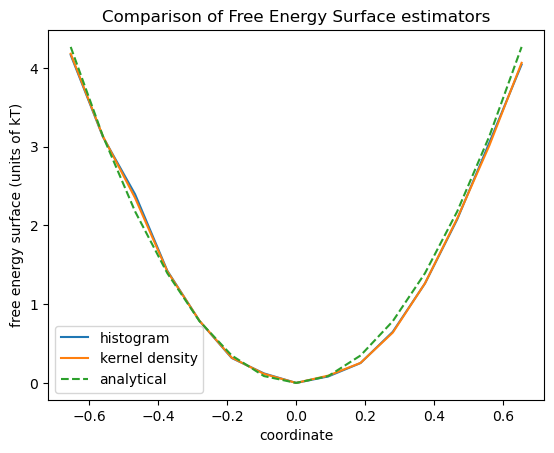

In [73]:
plt.plot(bin_centers[1:, ],f_ih[1:],label='histogram')
plt.plot(bin_centers[1:, ],f_ik[1:],label='kernel density')
plt.plot(bin_centers[1:, ],fes_analytical[1:],label='analytical',ls='--')
plt.title("Comparison of Free Energy Surface estimators")
plt.ylabel("free energy surface (units of kT)")
plt.xlabel("coordinate")
plt.legend()
plt.show()

In [76]:
print("============================================")
print("      Test 2: 2D free energy surface  ")
print("============================================")

      Test 2: 2D free energy surface  


In [217]:
xrange = [[-3, 3], [-3, 3]]
ndim = 2
nsamples = 500
u_kn, u_n, x_n, f_k_analytical = generate_fes_data(
    K0=K0,
    Ku=Ku,
    ndim=ndim,
    nbinsperdim=nbinsperdim,
    nsamples=nsamples,
    gridscale=gridscale,
    xrange=xrange,
)
numbrellas = np.shape(u_kn)[0]
N_k = nsamples * np.ones([numbrellas], int)
print("Solving for free energies of state ...")
mbar = MBAR(u_kn, N_k)

There are a total of 49 umbrellas.
Constructing umbrellas...
Generating 500 samples for each of 49 umbrellas...
Solving for free energies of state ...
INFO:pymbar.mbar_solvers:Reached a solution to within tolerance with hybr
INFO:pymbar.mbar_solvers:Solution found within tolerance!
INFO:pymbar.mbar_solvers:Final gradient norm: 2.7e-10


The dimensionless free energy is the integral of this, and can be computed as:<br>
  f(beta,K)           = - ln [ (2*np.pi/(Ko+Ku))^(d/2) exp[ -Ku*Ko mu' mu / 2(Ko +Ku)]<br>
  f(beta,K) - fzero   = -Ku*Ko / 2(Ko+Ku)  = 1/(1/(Ku/2) + 1/(K0/2))<br>
for computing harmonic samples

Can compare the free energies computed with MBAR if desired with<br>
f_k_analytical

Histogram bins are indexed using the scheme:<br>
index = 1 + np.floor((x[0] - xmin)/dx) + nbins*np.floor((x[1] - xmin)/dy)<br>
index = 0 is reserved for samples outside of the allowed domain

In [218]:
xmin = gridscale * (np.min(xrange[0][0]) - 1 / 2.0)
xmax = gridscale * (np.max(xrange[0][1]) + 1 / 2.0)
ymin = gridscale * (np.min(xrange[1][0]) - 1 / 2.0)
ymax = gridscale * (np.max(xrange[1][1]) + 1 / 2.0)
dx = (xmax - xmin) / nbinsperdim
dy = (ymax - ymin) / nbinsperdim
nbins = 1 + nbinsperdim**ndim
bin_centers = np.zeros([nbins, ndim], np.float64)

In [219]:
ibin = 1  # first reserved for something outside.
fes_analytical = np.zeros([nbins], np.float64)
minmu2 = 1000000
zeroindex = 0
# construct the bins and the fes
for i in range(nbinsperdim):
    xbin = xmin + dx * (i + 0.5)
    for j in range(nbinsperdim):
        # Determine (x,y) of bin center.
        ybin = ymin + dy * (j + 0.5)
        bin_centers[ibin, 0] = xbin
        bin_centers[ibin, 1] = ybin
        mu2 = xbin * xbin + ybin * ybin
        if mu2 < minmu2:
            minmu2 = mu2
            zeroindex = ibin
        fes_analytical[ibin] = K0 * mu2 / 2.0
        ibin += 1
fzero = fes_analytical[zeroindex]
fes_analytical -= fzero

In [220]:
bin_n = np.zeros([numbrellas * nsamples], int)
# Determine indices of those within bounds.
within_bounds = (x_n[:, 0] >= xmin) & (x_n[:, 0] < xmax) & (x_n[:, 1] >= ymin) & (x_n[:, 1] < ymax)
# Determine states for these.
xgrid = (x_n[within_bounds, 0] - xmin) / dx
ygrid = (x_n[within_bounds, 1] - ymin) / dy
bin_n[within_bounds] = 1 + xgrid.astype(int) + nbinsperdim * ygrid.astype(int)

Determine indices of bins that are not empty.

In [221]:
bin_counts = np.zeros([nbins], int)
for i in range(nbins):
    bin_counts[i] = (bin_n == i).sum()

Compute free energy surface, first using histograms weighted with MBAR

In [222]:
print("Computing free energy surface ...")
fes = FES(u_kn, N_k)

Computing free energy surface ...
INFO:pymbar.mbar_solvers:Reached a solution to within tolerance with hybr
INFO:pymbar.mbar_solvers:Solution found within tolerance!
INFO:pymbar.mbar_solvers:Final gradient norm: 2.7e-10


for 2D bins, we input a list of the bin edges in each dimension.

In [223]:
histogram_parameters["bin_edges"] = [
    np.linspace(xmin, xmax, nbinsperdim + 1),
    np.linspace(ymin, ymax, nbinsperdim + 1),
]  # list of histogram edges.
fes.generate_fes(u_n, x_n, fes_type="histogram", histogram_parameters=histogram_parameters)
delta = 0.0001  # to break ties in things being too close.

In [224]:
results = fes.get_fes(
    bin_centers + delta,
    reference_point="from-specified",
    fes_reference=[0, 0],
    uncertainty_method="analytical",
)
f_i = results["f_i"]
df_i = results["df_i"]

now generate the kernel density estimate

In [225]:
kde_parameters["bandwidth"] = 0.5 * dx
fes.generate_fes(u_n, x_n, fes_type="kde", kde_parameters=kde_parameters)
results_kde = fes.get_fes(bin_centers, reference_point="from-specified", fes_reference=[0, 0])
f_ik = results_kde["f_i"]

Show free energy and uncertainty of each occupied bin relative to lowest<br>
free energy

In [226]:
print("2D FES:")

2D FES:


In [87]:
print(f"{bin_counts[0]:d} counts out of {numbrellas * nsamples:d} counts not in any bin")
print("Uncertainties only calculated for histogram methods")
print(
    f"{'bin':>8s} {'x':>6s} {'y':>6s} {'N':>8s} {'f_hist':>10s} {'f_kde':>10s} {'true':>10s} {'err_hist':>10s} {'err_kde':>10s} {'df':>10s} {'sigmas':>8s}"
)
for i in range(1, nbins):
    if i == zeroindex:
        stdevs = 0
        df_i[0] = 0
    else:
        error = fes_analytical[i] - f_i[i]
        if df_i[i] > 0:
            stdevs = np.abs(error) / df_i[i]
        else:
            stdevs = np.nan
    print(
        f"{i:>8d} "
        f"{bin_centers[i, 0]:>6.2f} "
        f"{bin_centers[i, 1]:>6.2f} "
        f"{bin_counts[i]:>8d} "
        f"{f_i[i]:>10.3f} "
        f"{f_ik[i]:>10.3f} "
        f"{fes_analytical[i]:>10.3f} "
        f"{error:>10.3f} "
        f"{fes_analytical[i]-f_ik[i]:>10.3f} "
        f"{df_i[i]:>10.3f} "
        f"{stdevs:>8.2f}"
    )

199 counts out of 24500 counts not in any bin
Uncertainties only calculated for histogram methods
     bin      x      y        N     f_hist      f_kde       true   err_hist    err_kde         df   sigmas
       1  -0.65  -0.65        3      8.883      8.427      8.537     -0.347      0.110      0.602     0.58
       2  -0.65  -0.56       14      7.387      7.369      7.404      0.017      0.036      0.288     0.06
       3  -0.65  -0.47       18      6.636      6.382      6.446     -0.190      0.065      0.246     0.77
       4  -0.65  -0.37       28      5.770      5.593      5.662     -0.107      0.070      0.230     0.47
       5  -0.65  -0.28       30      5.300      5.004      5.052     -0.248      0.049      0.236     1.05
       6  -0.65  -0.19       32      4.617      4.459      4.617     -0.000      0.158      0.218     0.00
       7  -0.65  -0.09       29      4.315      4.112      4.356      0.041      0.243      0.213     0.19
       8  -0.65   0.00       22      4.176    